# Comparing ROQ with Neo and Bao on IMDB Synthetic Queries
## Roq Model Architecture
- query level data is processed by Graph Neural Networks using Pytorch-Geometric
- The plan level data is processed using TCNNs
- The aleatoric loss function is used


In [67]:
%load_ext autoreload
%autoreload 2
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import torch
import pandas as pd
import numpy as np
import pickle
from torch_geometric.loader import DataLoader
from util.eval_util import describe_plot, plot_step_curve, comput_uncertainty
from util.util import set_seed
from pyg_data import queryPlanPGDataset, queryPlanPGDataset_nosplit


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [68]:
files_id = 'job_syn_all_pluslongrun'
exp_id = 'job_syn'
labeled_data_dir='../labeled_data/'
seed = 0
train=False
try_gpu=True
reload_data = True
show_fig=True
num_workers = 10


In [69]:
plots_dir = './plots'
if not os.path.exists(plots_dir):
    os.mkdir(plots_dir)

In [70]:
if try_gpu:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
else:
    device = torch.device('cpu')

In [71]:
set_seed(seed)

pd.set_option("display.max_columns", 1000)
pd.set_option("display.max_rows", 200)

In [72]:
# load model parameters and path to model wights
from util.util import load_best_model_paths,load_model_params

models_path = os.path.join('..','lightning_models')
config_dir = os.path.join('..','config')

best_model_paths = load_best_model_paths('roq',exp_id,models_path)
roq_config = load_model_params('roq',config_dir)


In [73]:
# Load train, validation, and test datasets
print("loading train")
train_set = queryPlanPGDataset(
    split= 'train', files_id = files_id,
    labeled_data_dir=labeled_data_dir,
    force_reload=False, seed = seed,
    val_samples = 0.1, test_samples = 200
    )
print("{} queries and {} samples in training dataset: ".format(np.unique(np.array(train_set.query_id)).shape[0],train_set.len()))

print("loading val")
val_set = queryPlanPGDataset(
    split= 'val', files_id = files_id,
    )
print("{} queries and {} samples in vlidation dataset: ".format(np.unique(np.array(val_set.query_id)).shape[0],val_set.len()))

print("loading test")
test_set = queryPlanPGDataset(
    split= 'test', files_id = files_id,
    )
print("{} queries and {} samples in test dataset: ".format(np.unique(np.array(test_set.query_id)).shape[0],test_set.len()))

loading train
8546 queries and 94754 samples in training dataset: 
loading val
500 queries and 5600 samples in vlidation dataset: 
loading test
500 queries and 5432 samples in test dataset: 


In [74]:
print("loading job")
job_data_set = queryPlanPGDataset_nosplit(
    files_id = 'job_main', 
    labeled_data_dir=labeled_data_dir,
    force_reload=True,
    )
print("{} queries and {} samples in train dataset: ".format(np.unique(np.array(job_data_set.query_id)).shape[0],job_data_set.len()))

Loading the data ... 100%
113 queries and 1469 samples in train dataset: 


Done!


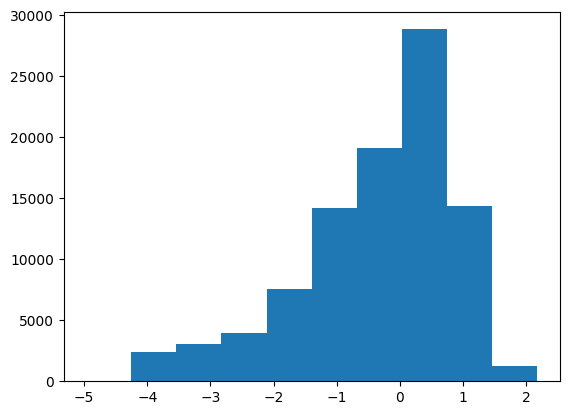

In [75]:
import matplotlib.pyplot as plt
plt.hist(np.log10(train_set.y))
plt.show()

In [76]:
pd.DataFrame(train_set.y).describe()

,0
count,94754.000000
mean,3.774166
std,9.748044
min,0.000011
25%,0.093677
50%,0.949405
75%,2.812395
max,149.630722


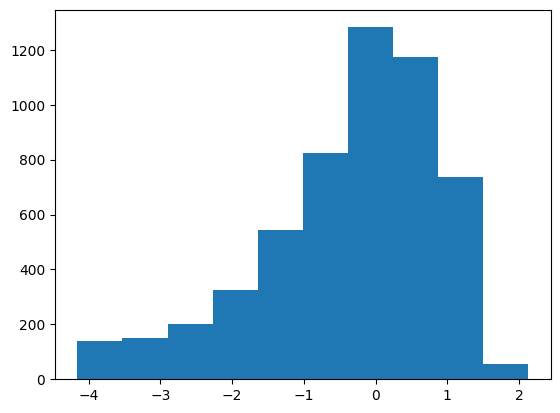

In [77]:
plt.hist(np.log10(test_set.y))
plt.show()

In [79]:
pd.DataFrame(test_set.y).describe()

,0
count,5432.000000
mean,3.786807
std,8.802352
min,0.000070
25%,0.097204
50%,0.916716
75%,2.956901
max,134.937012


In [80]:
from util.data_transform import *

# Perform data transformations on inputs 
drop_const = dropConst(train_set)
train_set = drop_const(train_set)
val_set = drop_const(val_set)
test_set = drop_const(test_set)
# job_data_set = drop_const(job_data_set)

null_imp = nullImputation(train_set)
train_set = null_imp(train_set)
val_set = null_imp(val_set)
test_set = null_imp(test_set)
# job_data_set = null_imp(job_data_set)

minmax_scale = minmaxScale(train_set)
train_set = minmax_scale(train_set)
val_set = minmax_scale(val_set)
test_set = minmax_scale(test_set)
# job_data_set = minmax_scale(job_data_set)

# Initialize data transformations on targets 
yTransFunc_log = target_log_transform(train_set)
# Transform targets for Roq
train_set = yTransFunc_log.transform(train_set)
val_set = yTransFunc_log.transform(val_set)
test_set = yTransFunc_log.transform(test_set)
# job_data_set = yTransFunc_log.transform(job_data_set)

In [81]:
plan_attr_shape = train_set[0].plan_attr.shape
plan_ord_shape = train_set[0].plan_ord.shape
graph_attr_shape= train_set[0].graph_attr.shape
edge_attr_shape = train_set[0].edge_attr_s.shape
node_attr_shape = train_set[0].x_s.shape

In [82]:
node_attr_shape

torch.Size([21, 6])

In [83]:
roq_config

{'node_embd_dim': 8,
 'query_module_out': 64,
 'qp_attheads': 2,
 'qp_gnn_ls': 2,
 'TCNNin': 256,
 'TCNNout': 64,
 'finalMLPin': 512,
 'finalMLPout': 128,
 'batch_size': 256,
 'dropout': 0.1710978438087516,
 'lr': 0.00135}

In [84]:
batch_size=roq_config['batch_size']

In [85]:
follow_batch = ['x_s']#,'edge_index_s','edge_index_t']

train_loader = DataLoader(train_set, batch_size=batch_size,
                         shuffle=False, num_workers=num_workers, 
                         follow_batch=follow_batch,
                        #  persistent_workers=True
                         )
val_loader = DataLoader(val_set, batch_size=batch_size,
                         shuffle=False, num_workers=num_workers, 
                         follow_batch=follow_batch,
                        #  persistent_workers=True
                         )
test_loader = DataLoader(test_set, batch_size=batch_size,
                         shuffle=False, num_workers=num_workers, 
                         follow_batch=follow_batch,
                        #  persistent_workers=True
                         )

In [61]:
job_data_loader = DataLoader(job_data_set, batch_size=batch_size,
                         shuffle=False, num_workers=num_workers, 
                         follow_batch=follow_batch,
                        #  persistent_workers=True
                         )

In [86]:
from util.custom_loss import aleatoric_loss

aleatoric_l = aleatoric_loss(device=device)


In [87]:
from lcm.roq_model import lcm_pl as roq
torch.set_float32_matmul_precision('high')

model = roq.load_from_checkpoint(
            best_model_paths[0], 
            num_node = node_attr_shape[0], 
            node_dim = node_attr_shape[1],
            edge_dim = edge_attr_shape[1],#fill_value =0, 
            numPlanFeat=plan_attr_shape,
            numPlanOrdFeat=plan_ord_shape,
            numQueryGraphFeat = graph_attr_shape[0],
            with_var = True, device = device, 
            criterion = aleatoric_l,
            **roq_config
            )

/database/config/db2inst1/miniconda3/envs/pyg311/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028


In [88]:
# Enables variational inference using MC dropout
from util.torch_util import LitMCdropoutModel

LitMCDPModel = LitMCdropoutModel(
    model, mc_iteration=10, 
    dropout=roq_config['dropout']
    )

In [89]:
import pytorch_lightning as pl

trainer = pl.Trainer(accelerator=device.type)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [90]:
########## Making predictions for Roq ###########
# Validation
ypreds = trainer.predict(model, val_loader)
ypreds_arr = torch.vstack(ypreds).numpy()

ypreds_mc = trainer.predict(LitMCDPModel, val_loader)
ypreds_mc = torch.hstack([torch.Tensor(ypreds_mc[b]) for b in range(len(ypreds_mc))])

ypreds_val_m, ypreds_val_Ud, ypreds_val_Um = comput_uncertainty(ypreds_mc)

# Test
ypreds_test = trainer.predict(model, test_loader)
ypreds_arr_test = torch.vstack(ypreds_test).numpy()
ypreds_tens_test_org=yTransFunc_log.inverse_transform(torch.Tensor(ypreds_arr_test))

ypreds_test_mc = trainer.predict(LitMCDPModel, test_loader)
ypreds_test_mc = torch.hstack([torch.Tensor(ypreds_test_mc[b]) for b in range(len(ypreds_test_mc))])

ypreds_test_m, ypreds_test_Ud, ypreds_test_Um = comput_uncertainty(ypreds_test_mc)
ypreds_test_m_org=yTransFunc_log.inverse_transform(torch.Tensor(ypreds_test_m))


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 22/22 [00:01<00:00, 20.67it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 22/22 [00:01<00:00, 11.41it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 22/22 [00:00<00:00, 48.19it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 22/22 [00:02<00:00,  8.74it/s]


In [91]:
from util.eval_util import plot2dhist, compute_spearmanr,lcm_model_eval

results_dir = os.path.join('..','results')

def eval(model,loader,yTransFunc):
# Validation
    ypreds = trainer.predict(model, loader)
    ypreds_arr = torch.vstack(ypreds).numpy()
    ypreds_tens_org=yTransFunc.inverse_transform(torch.Tensor(ypreds_arr))

    y_val = loader.dataset.y_t.numpy()
    plot2dhist(y_val,ypreds_arr[:,0],"y_actual","y_pred")
    spearmanr_coef4, _ = compute_spearmanr(ypreds_arr[:,0],y_val)
    
    q_error_num_joins, _ = lcm_model_eval(loader.dataset, ypreds_tens_org[:,0], 
            dataset_label = 'Test data', model_label = 'roq',
            load_from_disk=False, files_id = files_id,show_fig=True, results_dir=results_dir)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 371/371 [00:14<00:00, 26.34it/s]


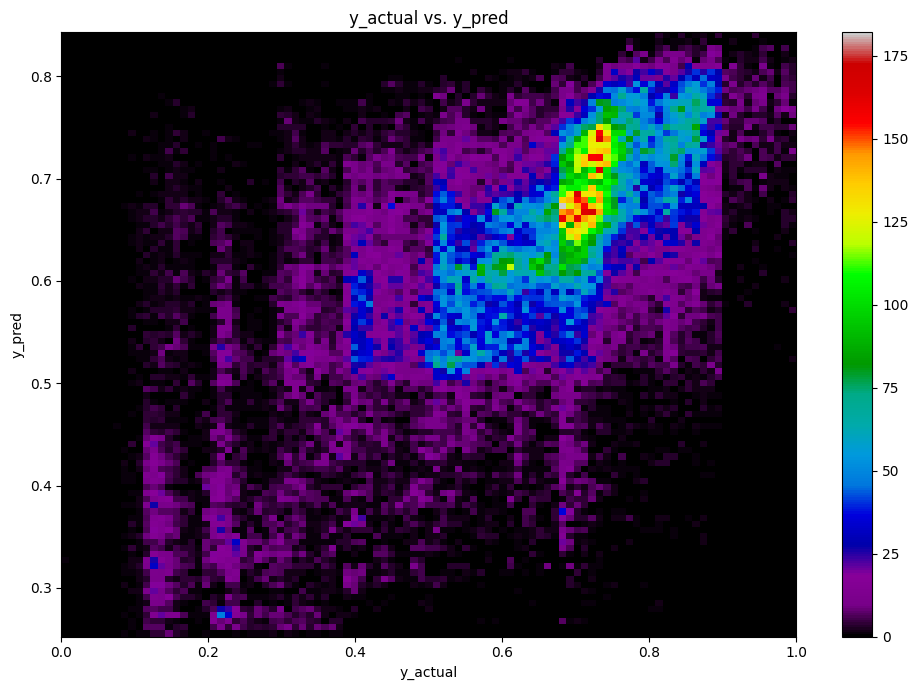

Spearman's Rank Correlation Coefficient: 0.6403248814672244
P-value: 0.0
There is a significant correlation.


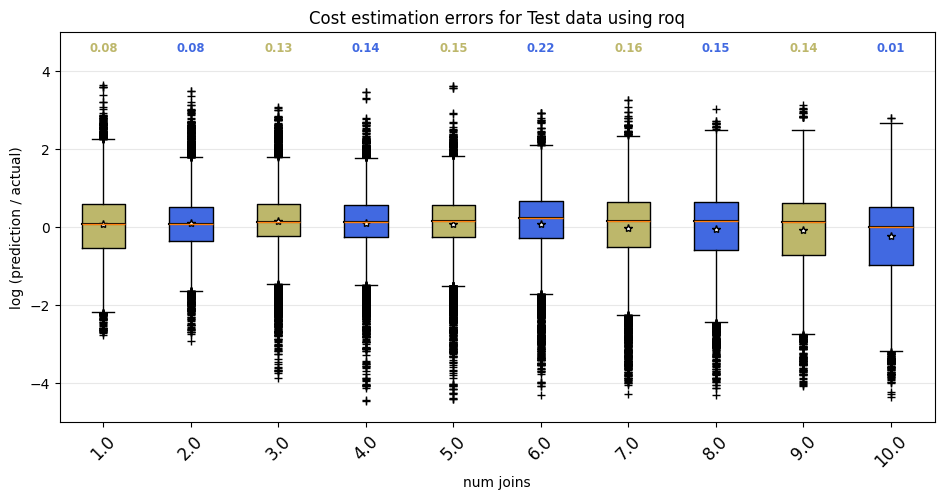

,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,overall q_error
count,11208.000000,10799.000000,10302.000000,9841.000000,9850.000000,8589.000000,9086.000000,8528.000000,8580.000000,7971.000000,94754.000000
mean,18.417141,12.959093,22.402929,38.202637,51.224827,46.939056,67.519836,59.885563,54.759907,78.910843,43.099644
std,97.089905,70.293053,167.954849,561.245544,695.744690,424.097626,504.814362,518.792664,417.838440,586.574768,444.873535
min,1.000861,1.000058,1.000081,1.000061,1.000587,1.000013,1.000108,1.000223,1.000147,1.000419,1.000013
0%,1.000861,1.000058,1.000081,1.000061,1.000587,1.000013,1.000108,1.000223,1.000147,1.000419,1.000013
10%,1.311383,1.195215,1.165997,1.172812,1.192088,1.221012,1.252996,1.294415,1.318674,1.275041,1.227030
20%,1.703952,1.413372,1.388195,1.421728,1.433650,1.519810,1.586226,1.622463,1.701334,1.641559,1.514784
30%,2.154408,1.702290,1.655382,1.730438,1.745535,2.003719,2.098011,2.127603,2.262888,2.201643,1.910588
40%,2.723613,2.107696,2.041324,2.113132,2.152549,2.678228,2.853466,2.917124,3.118221,3.076071,2.467599
50%,3.623128,2.696206,2.596827,2.677517,2.766252,3.634912,4.017930,4.278522,4.391529,4.697536,3.309866


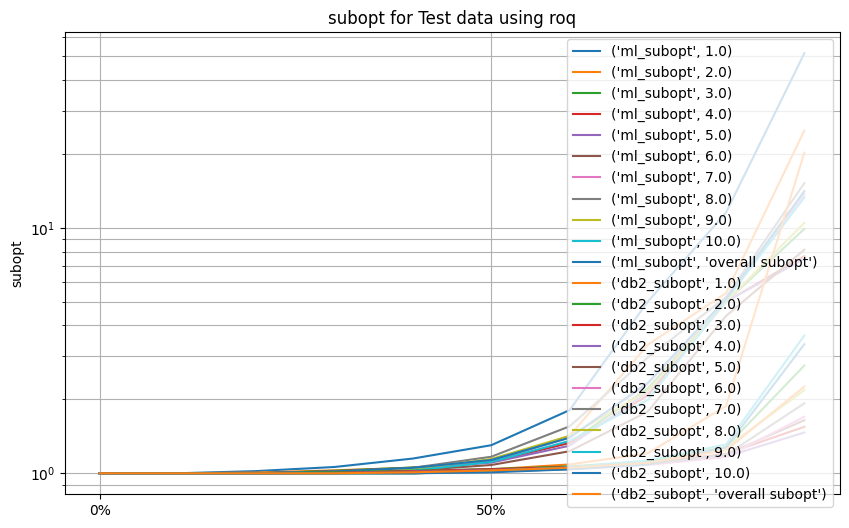

ml_subopt                                                      \
               1.0          2.0          3.0          4.0          5.0   
count   900.000000   887.000000   882.000000   865.000000   862.000000   
mean     49.628792    28.625725    19.075695    15.121437    14.402198   
std     277.800751   218.041245   184.671570   178.629715   151.485992   
min       1.000000     1.000000     1.000000     1.000000     1.000000   
0%        1.000000     1.000000     1.000000     1.000000     1.000000   
10%       1.000000     1.000000     1.000000     1.000000     1.000000   
20%       1.020634     1.006722     1.000057     1.000000     1.000000   
30%       1.060929     1.028149     1.024139     1.019425     1.015459   
40%       1.148245     1.053476     1.055751     1.051398     1.043030   
50%       1.300978     1.116987     1.113983     1.114330     1.105061   
60%       1.807310     1.419063     1.333042     1.329926     1.294793   
70%       5.000000     3.337999     2.214444     2.074069     2.136578   
80%      11.537902     5.419746     4.996452     5.000000     5.000000   
90%      51.349122    24.875816     9.894131     7.660190     7.472138   
max    4013.690918  5215.904297  4729.365723  4867.023926  3923.253662   

                                                                              \
                6.0           7.0           8.0            9.0          10.0   
count    849.000000    854.000000    800.000000     840.000000    807.000000   
mean      69.044991     80.746811     34.791836     248.804688    122.222893   
std      895.486755    744.281311    398.596100    5447.367676   1095.084595   
min        1.000000      1.000000      1.000000       1.000000      1.000000   
0%         1.000000      1.000000      1.000000       1.000000      1.000000   
10%        1.000000      1.000000      1.000000       1.000000      1.000000   
20%        1.000000      1.000000      1.000000       1.000000      1.000000   
30%        1.000000      1.003812      1.015146       1.000000      1.000000   
40%        1.027154      1.037877      1.052773       1.038963      1.025146   
50%        1.080641      1.122091      1.167769       1.143022      1.112540   
60%        1.229547      1.400480      1.552519       1.418612      1.354092   
70%        1.783550      2.311261      2.962416       2.162084      1.991613   
80%        4.372754      5.081553      5.212077       5.000000      5.065822   
90%        8.137002     13.700171     15.186001      10.473108     13.280881   
max    20771.941406  14860.001953  10330.596680  156123.406250  21721.533203   

                       db2_subopt                                         \
      overall subopt          1.0          2.0          3.0          4.0   
count    8546.000000   900.000000   887.000000   882.000000   865.000000   
mean       67.331696    10.978247    11.814139     4.629115     7.756575   
std      1789.730347    53.899895   111.712639    60.416836   157.907669   
min         1.000000     1.000000     1.000000     1.000000     1.000000   
0%          1.000000     1.000000     1.000000     1.000000     1.000000   
10%         1.000000     1.000000     1.000000     1.000000     1.000000   
20%         1.000000     1.000000     1.000000     1.000000     1.000000   
30%         1.016464     1.000000     1.010022     1.003587     1.001715   
40%         1.052432     1.013667     1.023826     1.020474     1.015687   
50%         1.132565     1.038338     1.040572     1.038267     1.031408   
60%         1.395180     1.086046     1.065528     1.059706     1.052585   
70%         2.335113     1.206602     1.120880     1.098114     1.087895   
80%         5.130897     1.878347     1.279651     1.199978     1.169464   
90%        14.101823    20.205485     2.746752     1.546516     1.465990   
max    156123.406250  1016.658081  2520.777832  1512.681396  4624.384277   

                                                                      \
              5.0       

In [92]:
eval(model,train_loader,yTransFunc_log)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 22/22 [00:01<00:00, 18.73it/s]


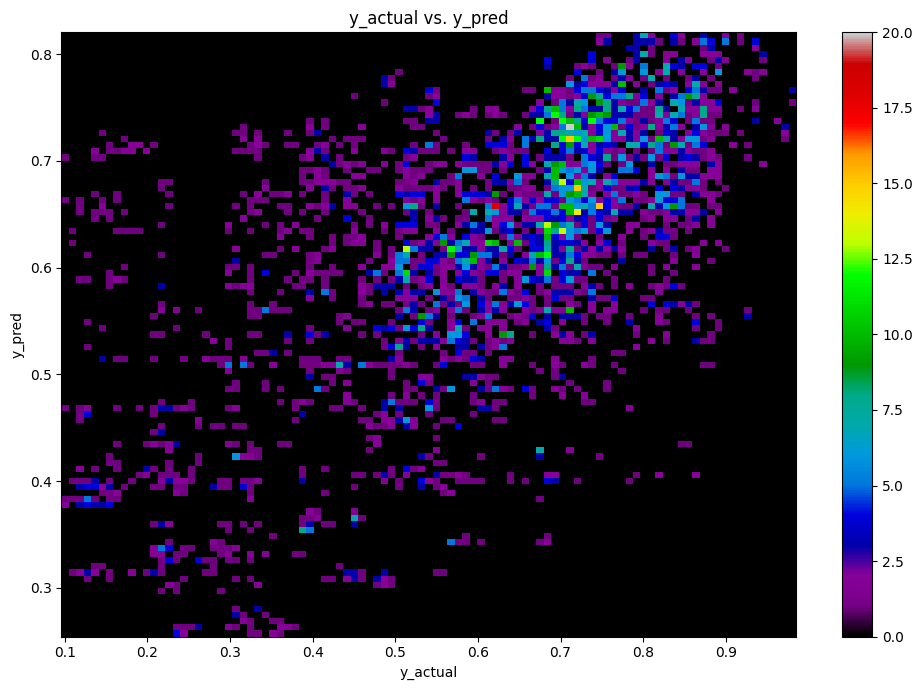

Spearman's Rank Correlation Coefficient: 0.6237054203812592
P-value: 0.0
There is a significant correlation.


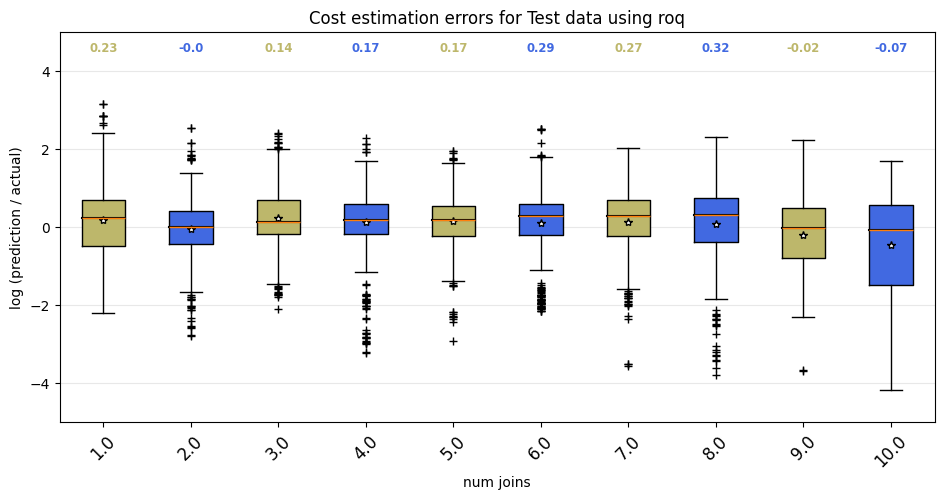

,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,overall q_error
count,612.000000,588.000000,682.000000,672.000000,542.000000,450.000000,515.000000,515.000000,442.000000,582.000000,5600.000000
mean,23.394238,14.231096,9.974094,27.195900,9.980252,15.953488,29.968443,61.953915,38.020096,324.183685,55.923450
std,105.480965,52.021614,24.640366,136.126617,44.299038,39.844620,260.664215,398.089233,323.970856,1362.673340,484.154877
min,1.000370,1.003939,1.004468,1.004315,1.000942,1.022274,1.000460,1.000134,1.000086,1.003666,1.000086
0%,1.000370,1.003939,1.004468,1.004315,1.000942,1.022274,1.000460,1.000134,1.000086,1.003666,1.000086
10%,1.564929,1.180436,1.201624,1.172160,1.149613,1.229823,1.308431,1.508030,1.206593,1.235631,1.235874
20%,1.851492,1.430208,1.377690,1.357713,1.404024,1.549578,1.501617,2.011205,1.714202,1.811847,1.536059
30%,2.328985,1.743890,1.579969,1.636961,1.735171,1.993918,2.159423,2.488656,2.257398,2.740092,1.944703
40%,2.968832,2.150403,1.881039,2.063911,2.086857,2.350270,2.733096,3.415163,3.109454,3.852989,2.466088
50%,3.767044,2.727720,2.530973,2.505257,2.612606,2.857194,3.721779,5.023275,4.308383,5.113682,3.324929


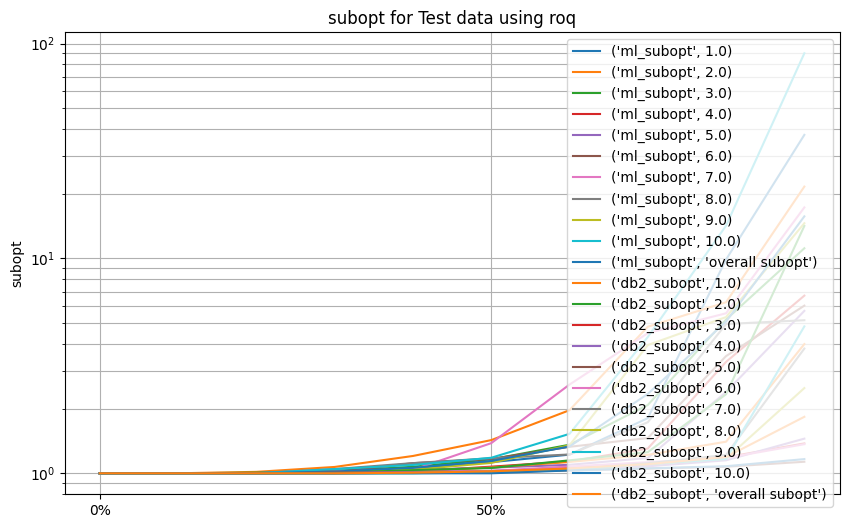

ml_subopt                                                             \
               1.0         2.0         3.0        4.0         5.0         6.0   
count    48.000000   48.000000   58.000000  60.000000   50.000000   42.000000   
mean     43.101940    9.503325    8.819803   3.729914    4.705600    9.300932   
std     222.084305   22.019491   26.398827   8.102202   16.861794   43.243748   
min       1.000000    1.000000    1.000000   1.000000    1.000000    1.000000   
0%        1.000000    1.000000    1.000000   1.000000    1.000000    1.000000   
10%       1.000000    1.000000    1.000000   1.000000    1.000000    1.000000   
20%       1.000000    1.015429    1.006400   1.000000    1.000000    1.000000   
30%       1.027009    1.070154    1.023581   1.010807    1.002391    1.012283   
40%       1.057737    1.203780    1.072116   1.020373    1.036205    1.114327   
50%       1.126702    1.426746    1.161334   1.073297    1.062163    1.164973   
60%       1.221129    1.965794    1.357622   1.135338    1.094870    1.328061   
70%       1.805277    4.808117    2.078437   1.303727    1.177805    1.458696   
80%       9.880421    6.253838    5.192004   3.299408    2.389942    3.511478   
90%      37.588812   21.592497   11.148779   6.710695    5.698850    6.027711   
max    1534.510742  122.589684  161.898178  53.234627  119.152214  281.220795   

                                                                          \
               7.0          8.0         9.0          10.0 overall subopt   
count    47.000000    47.000000   46.000000     54.000000     500.000000   
mean    123.338371    75.202644   31.039328    472.722046      80.345085   
std     774.231445   498.337372  121.030533   2481.617188     870.924866   
min       1.000000     1.000000    1.000000      1.000000       1.000000   
0%        1.000000     1.000000    1.000000      1.000000       1.000000   
10%       1.000000     1.000000    1.000000      1.000000       1.000000   
20%       1.000000     1.002092    1.000000      1.000000       1.000000   
30%       1.018977     1.046375    1.003288      1.045940       1.018529   
40%       1.038522     1.114916    1.039907      1.093237       1.060612   
50%       1.380836     1.174790    1.117453      1.180882       1.141065   
60%       2.587227     1.223054    1.350224      1.525524       1.332672   
70%       4.489154     1.727892    3.951649      4.306848       2.340109   
80%       5.554544     4.949779    5.332892     14.201650       5.082094   
90%      17.271078     5.156472   14.579871     90.113348      15.693763   
max    5314.297363  3418.881592  747.482788  16998.312500   16998.312500   

      db2_subopt                                                          \
             1.0         2.0        3.0        4.0        5.0        6.0   
count  48.000000   48.000000  58.000000  60.000000  50.000000  42.000000   
mean    4.309189    6.002246   1.193673   1.278272   1.539981   2.647823   
std    10.853582   18.179523   0.537502   1.084113   3.234566   8.548762   
min     1.000000    1.000000   1.000000   1.000000   1.000000   1.000000   
0%      1.000000    1.000000   1.000000   1.000000   1.000000   1.000000   
10%     1.000000    1.000000   1.000000   1.000000   1.000000   1.000000   
20%     1.000000    1.000000   1.000000   1.000000   1.000000   1.000000   
30%     1.000000    1.004958   1.005360   1.004448   1.000000   1.000000   
40%     1.020316    1.033642   1.009203   1.013603   1.005938   1.003827   
50%     1.063537    1.058587   1.020166   1.026986   1.010950   1.025205   
60%     1.129362    1.148343   1.059330   1.054215   1.032148   1.075515   
70%     1.217988    1.253822   1.096939   1.077147   1.051252   1.126255   
80%     1.402870    2.332793   1.186552   1.149382   1.072805   1.178106   
90%     3.993213   14.157587   1.377132   1.449418   1.131380   1.365866   
max    47.474827  120.524193   4.641863   9.197618  23.830442  56.244160   

                                             

In [93]:
eval(model,val_loader,yTransFunc_log)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 22/22 [00:01<00:00, 19.59it/s]


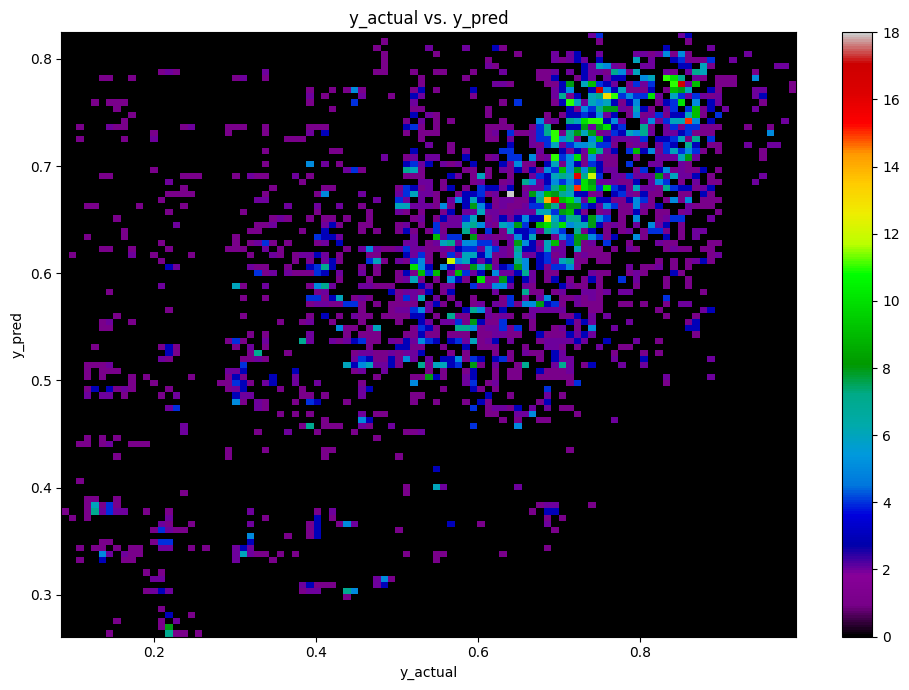

Spearman's Rank Correlation Coefficient: 0.6130331311476584
P-value: 0.0
There is a significant correlation.


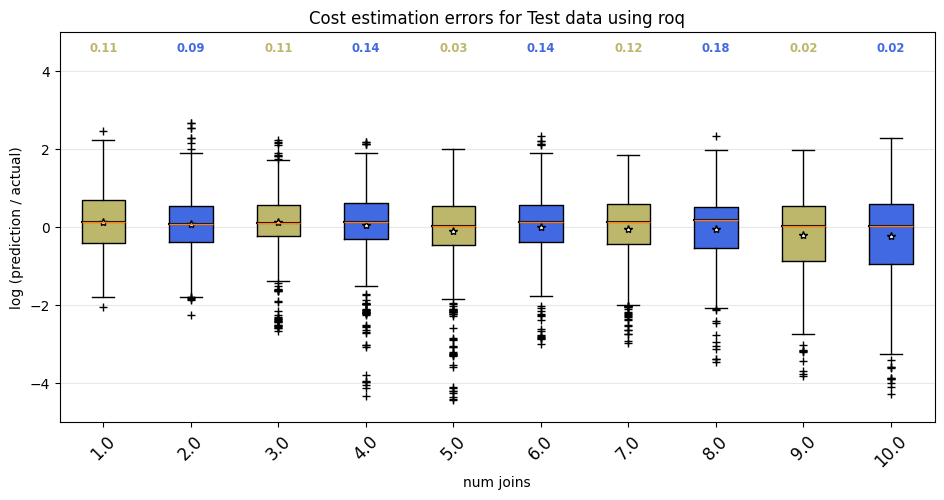

,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,overall q_error
count,538.000000,780.000000,565.000000,605.000000,648.000000,446.000000,359.000000,452.000000,464.000000,575.000000,5432.000000
mean,13.626410,9.548855,16.659761,154.436691,286.488678,25.572191,28.316395,39.095146,79.967720,193.279968,90.344910
std,29.719543,32.731918,55.268166,1330.052856,2196.676514,98.082558,93.106346,229.707932,512.323303,1246.424561,986.685486
min,1.000147,1.005217,1.004575,1.000786,1.004031,1.010667,1.010882,1.001559,1.001633,1.031366,1.000147
0%,1.000147,1.005217,1.004575,1.000786,1.004031,1.010667,1.010882,1.001559,1.001633,1.031366,1.000147
10%,1.292380,1.246820,1.168081,1.204773,1.153689,1.253605,1.149882,1.298097,1.310058,1.622127,1.241615
20%,1.663523,1.502476,1.384226,1.519541,1.513659,1.506634,1.421408,1.634316,1.598639,2.356229,1.556023
30%,1.953400,1.837806,1.645235,1.818718,1.891166,1.904970,1.822135,2.039994,1.921870,3.053818,1.930229
40%,2.457223,2.334944,1.990242,2.159558,2.450393,2.394481,2.550850,2.543181,2.431979,3.718817,2.444252
50%,3.363361,2.901464,2.379276,2.966381,3.191792,3.407709,3.573958,3.257727,3.866468,4.789873,3.257768


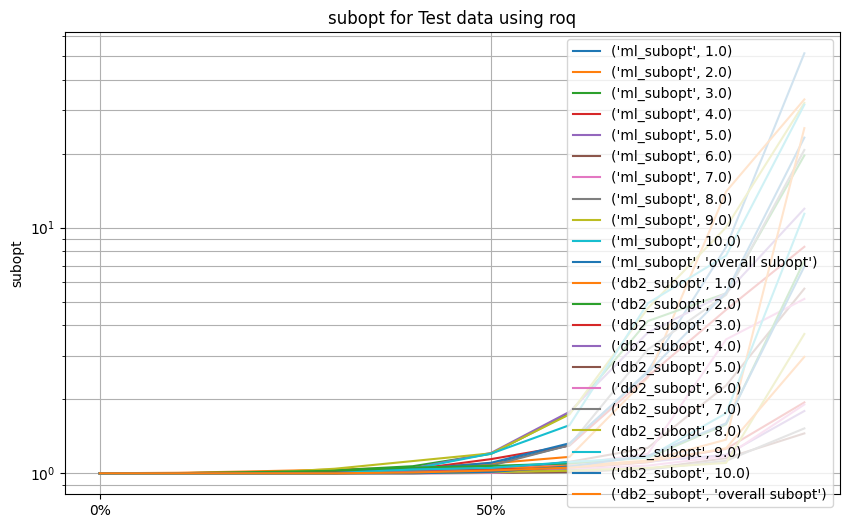

ml_subopt                                                  \
              1.0          2.0         3.0        4.0         5.0   
count   46.000000    60.000000   49.000000  53.000000   60.000000   
mean    14.127102    45.363575   14.946338   4.525877   21.566931   
std     35.346825   244.371506   46.039055   9.652704  122.866493   
min      1.000000     1.000000    1.000000   1.000000    1.000000   
0%       1.000000     1.000000    1.000000   1.000000    1.000000   
10%      1.000000     1.004583    1.000000   1.000000    1.000000   
20%      1.013414     1.018740    1.000000   1.000000    1.000000   
30%      1.021821     1.035010    1.028172   1.000658    1.004597   
40%      1.039351     1.054529    1.068664   1.037700    1.047903   
50%      1.088258     1.097432    1.200162   1.142210    1.210744   
60%      1.299789     1.166134    1.751983   1.296905    1.778985   
70%      2.606431     2.454502    4.163285   2.479013    3.735042   
80%      8.326934    14.012608    5.403741   4.627831    5.405008   
90%     51.264053    33.259168   19.677718   8.356083   11.940182   
max    202.195038  1877.803345  278.971008  57.498405  952.521667   

                                                                      \
               6.0        7.0          8.0          9.0         10.0   
count    50.000000  35.000000    44.000000    44.000000    59.000000   
mean     29.590010   2.705955    56.115074    38.587978    26.572287   
std     188.169205   4.693257   332.558777   186.697433   133.203293   
min       1.000000   1.000000     1.000000     1.000000     1.000000   
0%        1.000000   1.000000     1.000000     1.000000     1.000000   
10%       1.000000   1.000000     1.000000     1.000000     1.000000   
20%       1.000000   1.000000     1.000000     1.000000     1.000000   
30%       1.000000   1.001026     1.001369     1.043489     1.000000   
40%       1.010237   1.024364     1.022419     1.121441     1.042239   
50%       1.030005   1.033044     1.074524     1.205138     1.202947   
60%       1.112941   1.086675     1.301128     1.736597     1.569723   
70%       1.268549   1.200064     3.188944     4.689804     4.918675   
80%       2.277047   3.508200     5.324471    10.027444     7.692628   
90%       5.643821   5.125564    20.715184    32.176930    31.665374   
max    1332.848145  27.278950  2210.544434  1239.070312  1015.077271   

                      db2_subopt                                      \
      overall subopt         1.0          2.0         3.0        4.0   
count     500.000000   46.000000    60.000000   49.000000  53.000000   
mean       25.893652    9.213398    24.602755    7.360439   1.403589   
std       165.835190   25.184370   157.070663   39.470013   1.303373   
min         1.000000    1.000000     1.000000    1.000000   1.000000   
0%          1.000000    1.000000     1.000000    1.000000   1.000000   
10%         1.000000    1.000000     1.000832    1.000000   1.000000   
20%         1.000000    1.000000     1.011495    1.000000   1.000000   
30%         1.011779    1.000000     1.023824    1.004501   1.000000   
40%         1.038233    1.013679     1.054504    1.013366   1.013526   
50%         1.103934    1.037130     1.071309    1.036201   1.023172   
60%         1.324447    1.071653     1.096772    1.046847   1.049821   
70%         2.568633    1.125874     1.157019    1.108870   1.115048   
80%         5.435284    1.370226     1.580527    1.256781   1.188742   
90%        23.254596   25.410624     7.333089    1.943111   1.792693   
max      2210.544434  139.138779  1218.184204  277.278717   8.634650   

                                                                             \
             5.0        6.0        7.0        8.0          9.0         10.0   
count  60.000000  50.000000  35.000000  44.000000    44.000000    59.000000   
mean    1.545603   1.465354   1.783020   2.939617   163.343475    21.688826   
std     2.609217   2.007706   3.557197   6.564025  1053.494629   132

In [94]:
eval(model,test_loader,yTransFunc_log)


In [99]:
import pickle


with open('../results/qerror_dict_{}.pkl'.format(exp_id), 'rb') as file:
    qerror_dict = pickle.load(file)

with open('../results/corr_dict_{}.pkl'.format(exp_id), 'rb') as file:
    corr_dict = pickle.load(file)

# with open('.\\results\\qerror_dict_{}.pkl'.format(wlshift_exp_id), 'rb') as file:
#     qerror_wlshift_dict = pickle.load(file)

# with open('.\\results\\corr_dict_{}.pkl'.format(wlshift_exp_id), 'rb') as file:
#     corr_wlshift_dict = pickle.load(file)
    
with open('../results/rt_res_dict_{}.pkl'.format(exp_id), 'rb') as file:
    rt_res_dict = pickle.load(file)

with open('../results/so_res_dict_{}.pkl'.format(exp_id), 'rb') as file:
    so_res_dict = pickle.load(file)

with open('../results/agg_res_dict_{}.pkl'.format(exp_id), 'rb') as file:
    agg_res_dict = pickle.load(file)

In [100]:
runtimes_all = []
for i in rt_res_dict:
    runtimes_all.append(rt_res_dict[i].values)
runtimes_all=np.array(runtimes_all)
runtimes_all_df = rt_res_dict[0].copy()
runtimes_all_df.loc[:, :] = runtimes_all.mean(axis=0)
runtimes_all_df

,optimizer,optimizer pruned,Neo,Bao,base model,base model pruned,mc dropout,mc dropout pruned,conservative,cons. data unc.,cons. model unc.,cons. prun. RN,cons. prun. SO,cons. prun. data unc. RN,cons. prun. data unc. SO,cons. prun. model unc. RN,cons. prun. model unc. SO,risk,risk data unc.,risk model unc.,risk prun. RN,risk prun. SO,risk prun. data unc. RN,risk prun. data unc. SO,risk prun. model unc. RN,risk prun. model unc. SO,best
0,15.407404,15.407404,18.464284,87.519361,70.549006,53.688237,18.635150,17.580867,20.949241,18.698904,19.814094,21.050264,17.546344,18.698904,18.698904,19.814094,18.744667,18.635150,18.635150,18.499069,17.580867,17.630301,18.715970,18.698904,18.698904,17.525664,15.250187
1,2.696835,2.708402,5.324371,2.705011,10.571668,5.296621,10.106908,7.926596,5.343312,5.343312,10.082026,5.343312,4.876514,5.343312,5.343312,10.082026,12.704656,10.106908,10.106908,10.549226,7.926596,4.876514,5.328848,2.716856,5.328848,10.549226,2.685884
2,0.004292,5.569533,11.134783,0.004125,0.004213,16.700034,0.346423,0.346272,0.597893,0.597942,0.345755,0.688603,0.687982,0.597942,0.688653,0.345755,0.345750,0.346398,0.346398,0.345755,0.346272,0.346340,0.346424,0.346424,0.688653,0.345755,0.000737
3,0.952072,0.952072,1.280656,1.182394,1.070655,1.074417,1.072264,1.024841,1.024289,1.054353,1.050968,1.063416,1.036840,1.024289,1.041554,1.026326,1.026326,1.072264,1.072264,1.072264,1.024841,1.082402,1.028623,1.099667,1.082402,1.084011,0.951456
4,24.076836,23.927682,20.896730,40.352180,39.264789,23.151763,99.764877,59.658476,60.004084,60.004084,58.569777,79.272462,39.315215,80.623393,60.010992,37.754014,39.111853,99.764877,99.764877,99.764877,59.658476,59.814537,101.122716,80.510314,81.712092,39.111853,16.905300
5,0.002446,0.002446,0.181395,0.136678,0.093591,0.004817,0.049595,0.092505,0.092201,0.049437,0.094323,0.094019,0.092069,0.049437,0.051259,0.094323,0.094323,0.049595,0.049595,0.049595,0.092505,0.092505,0.051369,0.096099,0.094129,0.092505,0.002429
6,1.014806,1.014806,1.014806,1.014806,1.014806,1.014806,1.014806,1.014806,1.014806,1.014806,1.014806,1.014806,1.014806,1.014806,1.014806,1.014806,1.014806,1.014806,1.014806,1.014806,1.014806,1.014806,1.014806,1.014806,1.014806,1.014806,1.014806
7,0.077461,0.077461,0.077461,0.077461,0.077461,0.077461,0.077461,0.077461,0.077461,0.077461,0.077461,0.077461,0.077461,0.077461,0.077461,0.077461,0.077461,0.077461,0.077461,0.077461,0.077461,0.077461,0.077461,0.077461,0.077461,0.077461,0.077461
8,18.919088,18.928751,80.610893,51.623579,79.460173,65.588140,50.482521,22.513420,36.652571,36.652571,64.344228,36.630478,37.957893,36.652571,51.787843,49.241384,49.241384,35.356913,35.356913,64.344228,22.513420,51.633242,50.482521,51.633242,37.648691,49.241384,18.919088
9,6.333922,6.333922,6.032482,6.411711,6.519315,5.787068,16.545987,16.553929,6.033256,11.088404,16.131608,6.405643,10.588315,11.088404,6.467547,16.131608,11.072412,16.545987,16.545987,16.545987,16.553929,11.056548,6.467547,6.033256,6.033256,11.540645,4.088558


In [101]:
subopts_all = []
for i in so_res_dict:
    subopts_all.append(so_res_dict[i].values)
subopts_all=np.array(subopts_all)
subopts_all_df = so_res_dict[0].copy()
subopts_all_df.loc[:, :] = subopts_all.mean(axis=0)
subopts_all_df

,optimizer,optimizer pruned,Neo,Bao,base model,base model pruned,mc dropout,mc dropout pruned,conservative,cons. data unc.,cons. model unc.,cons. prun. RN,cons. prun. SO,cons. prun. data unc. RN,cons. prun. data unc. SO,cons. prun. model unc. RN,cons. prun. model unc. SO,risk,risk data unc.,risk model unc.,risk prun. RN,risk prun. SO,risk prun. data unc. RN,risk prun. data unc. SO,risk prun. model unc. RN,risk prun. model unc. SO
0,1.010309,1.010309,1.210758,5.738904,4.626108,3.520497,1.221962,1.152830,1.373704,1.226143,1.299269,1.380328,1.150566,1.226143,1.226143,1.299269,1.229143,1.221962,1.221962,1.213039,1.152830,1.156071,1.227262,1.226143,1.226143,1.149210
1,1.004077,1.008384,1.982353,1.007122,3.936011,1.972022,3.762973,2.951206,1.989405,1.989405,3.753709,1.989405,1.815609,1.989405,1.989405,3.753709,4.730159,3.762973,3.762973,3.927655,2.951206,1.815609,1.984020,1.011532,1.984020,3.927655
2,5.819593,7552.639056,15099.471775,5.593663,5.713353,22646.304494,469.771290,469.567346,810.780472,810.846945,468.865826,933.789977,932.946783,810.846945,933.856450,468.865826,468.858649,469.738054,469.738054,468.865826,469.567346,469.659037,469.773295,469.773295,933.856450,468.865826
3,1.000648,1.000648,1.345996,1.242721,1.125281,1.129235,1.126972,1.077129,1.076549,1.108148,1.104590,1.117673,1.089741,1.076549,1.094695,1.078691,1.078691,1.126972,1.126972,1.126972,1.077129,1.137628,1.081104,1.155773,1.137628,1.139318
4,1.424218,1.415395,1.236105,2.386954,2.322632,1.369497,5.901396,3.528981,3.549424,3.549424,3.464581,4.689208,2.325615,4.769119,3.549833,2.233265,2.313585,5.901396,5.901396,5.901396,3.528981,3.538212,5.981717,4.762430,4.833519,2.313585
5,1.007066,1.007066,74.671450,56.263657,38.526823,1.983021,20.415821,38.079792,37.954500,20.350947,38.828207,38.702915,37.900147,20.350947,21.100775,38.828207,38.828207,20.415821,20.415821,20.415821,38.079792,38.079792,21.145922,39.558995,38.748062,38.079792
6,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
7,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
8,1.000000,1.000511,4.260823,2.728650,4.200000,3.466771,2.668338,1.189984,1.937333,1.937333,3.401022,1.936165,2.006328,1.937333,2.737333,2.602736,2.602736,1.868849,1.868849,3.401022,1.189984,2.729161,2.668338,2.729161,1.989984,2.602736
9,1.549183,1.549183,1.475455,1.568208,1.594527,1.415430,4.046901,4.048843,1.475644,2.712058,3.945550,1.566724,2.589743,2.712058,1.581865,3.945550,2.708146,4.046901,4.046901,4.046901,4.048843,2.704266,1.581865,1.475644,1.475644,2.822669


In [102]:
agg_res_all = []
for i in agg_res_dict:
    agg_res_all.append(agg_res_dict[i].values)
agg_res_all=np.array(agg_res_all)
agg_res_all_df = agg_res_dict[0].copy()
agg_res_all_var_df = agg_res_dict[0].copy()
agg_res_all_df.loc[:, :] = agg_res_all.mean(axis=0)
agg_res_all_var_df.loc[:, :] = agg_res_all.std(axis=0)

In [103]:
labels = [
        # 'optimizer pruned',
        'Neo','Bao',
        # 'Neo+','Bao+',
        'base model',#'base model pruned',
        # 'mc dropout','mc dropout pruned',
        'conservative','cons. prun. RN','cons. prun. SO',
        'risk','risk prun. RN','risk prun. SO',
        ]
columns =['improved_runtime','regressed_runtime','total_runtime_change%',
          'mean','50%','70%','90%','95%','99%'
          ]
sub = agg_res_all_df.loc[labels,columns]
sub[['improved_runtime','regressed_runtime']]=sub[['improved_runtime','regressed_runtime']]/runtimes_all_df.optimizer.sum()
sub

,improved_runtime,regressed_runtime,total_runtime_change%,mean,50%,70%,90%,95%,99%
Neo,0.198199,0.724237,0.526038,141.885117,1.191575,3.137588,16.168891,63.685933,1800.423629
Bao,0.167659,0.762484,0.594825,51.132046,1.294837,3.129212,16.996753,57.984050,913.857688
base model,0.174152,0.804441,0.630289,59.260645,1.219321,3.873532,18.670014,61.814041,1082.735362
conservative,0.220060,0.968477,0.748417,48.715286,1.257611,4.078953,23.209613,78.732834,1005.113574
cons. prun. RN,0.189721,0.914542,0.724821,78.115238,1.261681,3.861316,23.463198,72.510973,1244.327577
cons. prun. SO,0.222669,0.786240,0.563571,42.109858,1.217541,3.663269,20.304699,62.721227,1096.117514
risk,0.199806,0.895233,0.695428,72.816950,1.270053,3.899916,20.986585,70.515189,1099.382172
risk prun. RN,0.193589,0.923857,0.730268,67.804997,1.292404,4.073565,23.775947,55.650526,786.224126
risk prun. SO,0.195402,0.780914,0.585512,45.400147,1.227475,3.457280,20.426360,56.672475,812.734520


In [104]:
agg_res_all_df.loc[labels,:].sort_values(by='total_runtime_change%')

,improved,improved_runtime,average_improvement,regressed,regressed_runtime,average_regression,unchanged,total_runtime_change%,total_runtime_change,average_runtime_change,total_subopt,mean,50%,60%,70%,80%,90%,95%,99%,max
Neo,0.290,272.459985,4.708707,0.432,995.593481,11.501373,0.278,0.526038,723.133495,3.615667,1.526038,141.885117,1.191575,1.538454,3.137588,5.534757,16.168891,63.685933,1800.423629,19402.975606
cons. prun. SO,0.285,306.097960,5.381650,0.506,1080.826786,10.690330,0.209,0.563571,774.728826,3.873644,1.563571,42.109858,1.217541,1.732160,3.663269,6.448127,20.304699,62.721227,1096.117514,4030.401993
risk prun. SO,0.301,268.614884,4.472452,0.480,1073.506369,11.228699,0.219,0.585512,804.891486,4.024457,1.585512,45.400147,1.227475,1.651461,3.457280,6.014203,20.426360,56.672475,812.734520,4278.119162
Bao,0.247,230.477710,4.642163,0.444,1048.170538,11.858272,0.309,0.594825,817.692828,4.088464,1.594825,51.132046,1.294837,1.735878,3.129212,5.918261,16.996753,57.984050,913.857688,5164.994064
base model,0.253,239.403040,4.751634,0.435,1105.848293,12.767067,0.312,0.630289,866.445252,4.332226,1.630289,59.260645,1.219321,1.673136,3.873532,6.927118,18.670014,61.814041,1082.735362,6205.951755
risk,0.283,274.668495,4.795518,0.493,1230.657975,12.391233,0.224,0.695428,955.989480,4.779947,1.695428,72.816950,1.270053,1.845797,3.899916,7.042211,20.986585,70.515189,1099.382172,8434.858092
cons. prun. RN,0.260,260.805306,5.013069,0.516,1257.200757,12.178995,0.224,0.724821,996.395451,4.981977,1.724821,78.115238,1.261681,1.812833,3.861316,6.897834,23.463198,72.510973,1244.327577,8360.802409
risk prun. RN,0.292,266.122779,4.569992,0.498,1270.006720,12.806528,0.210,0.730268,1003.883941,5.019420,1.730268,67.804997,1.292404,1.885473,4.073565,6.972963,23.775947,55.650526,786.224126,8624.226472
conservative,0.266,302.511510,5.689197,0.517,1331.344592,12.852747,0.217,0.748417,1028.833082,5.144165,1.748417,48.715286,1.257611,1.736570,4.078953,7.475273,23.209613,78.732834,1005.113574,4616.697624


In [105]:
sub = agg_res_all_df.loc[labels,:]
sub_var = agg_res_all_var_df.loc[labels,:]

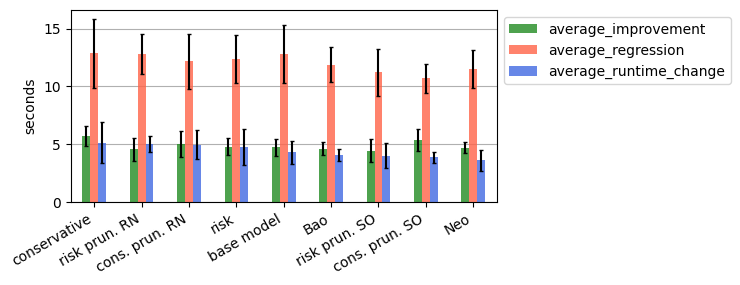

In [106]:
import matplotlib.pyplot as plt
features = ["average_improvement","average_regression","average_runtime_change"]
sub = sub.sort_values(by='total_runtime_change%',ascending=False)
ax = sub.loc[:,features].plot.bar(logy=False,figsize=[5.5,2.5],
            color=['forestgreen','tomato','royalblue'], yerr=sub_var.loc[:,features],
               align='center', alpha=0.8, ecolor='black', capsize=1.5)
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.xticks(rotation=30,ha='right')
plt.ylabel('seconds')
ax.grid(visible=True,which='major',axis='y')
ax.set_axisbelow(True)
# plt.show()
plt.savefig('./plots/roq_neo_bao_avg_runtime_bar_{}.png'.format(exp_id),bbox_inches='tight',dpi=300)

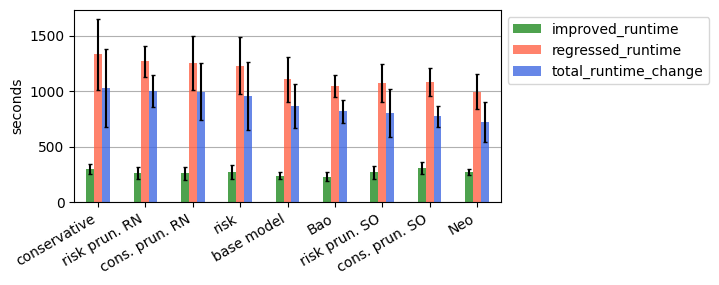

In [107]:
import matplotlib.pyplot as plt

features = ["improved_runtime","regressed_runtime","total_runtime_change"]
sub = sub.sort_values(by='total_runtime_change%',ascending=False)
ax = sub.loc[:,features].plot.bar(logy=False,figsize=[5.5,2.5],
            color=['forestgreen','tomato','royalblue'], yerr=sub_var.loc[:,features],
               align='center', alpha=0.8, ecolor='black', capsize=1.5)
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.xticks(rotation=30,ha='right')
plt.ylabel('seconds')
ax.grid(visible=True,which='major',axis='y')
ax.set_axisbelow(True)
# plt.show()
# plt.savefig('./plots/roq_neo_bao_tot_runtime_bar_{}.png'.format(exp_id),bbox_inches='tight',dpi=300)

In [108]:
runtimes_all_df.optimizer.sum()

1374.67862200737

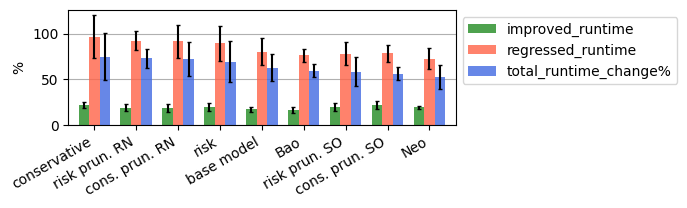

In [109]:
import matplotlib.pyplot as plt

sub = sub.sort_values(by='total_runtime_change%',ascending=False)
sub_perc = sub.copy()
sub_var_perc=sub_var.copy()
sub_perc[["improved_runtime","regressed_runtime"]] = sub_perc[["improved_runtime","regressed_runtime"]]/runtimes_all_df.optimizer.sum()
sub_var_perc[["improved_runtime","regressed_runtime"]] = sub_var_perc[["improved_runtime","regressed_runtime"]]/runtimes_all_df.optimizer.sum()
sub_perc=sub_perc*100
sub_var_perc=sub_var_perc*100
ax = sub_perc.loc[sub_perc.index,["improved_runtime","regressed_runtime","total_runtime_change%"]].plot.bar(logy=False,
                            figsize=[5,1.5], yerr=sub_var_perc, capsize=1.5,
                            color=['forestgreen','tomato','royalblue'],alpha=0.8,width=0.75)
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.xticks(rotation=30,ha='right')
plt.ylabel('%')
ax.grid(visible=True,which='major',axis='y')
ax.set_axisbelow(True)
# plt.show()
plt.savefig('./plots/roq_neo_bao_tot_runtime_bar_{}.png'.format(exp_id),bbox_inches='tight',dpi=300)

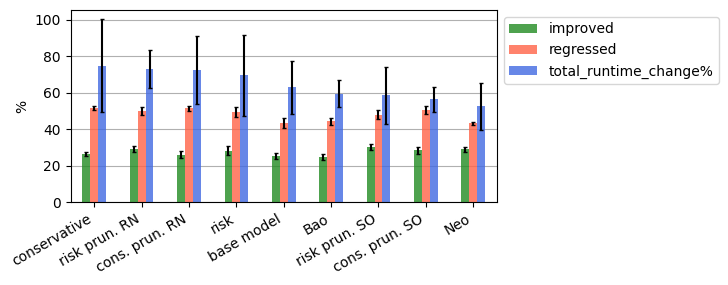

In [110]:
import matplotlib.pyplot as plt

# sub = sub.sort_values(by='total_runtime_change%',ascending=False)
# sub_perc=sub*100
# ax = sub_perc.loc[sub.index,["improved","regressed","total_runtime_change%"]].plot.bar(logy=False,figsize=[5.5,2.5],
#                               color=['forestgreen','tomato','royalblue'])

features = ["improved","regressed","total_runtime_change%"]
sub = sub.sort_values(by='total_runtime_change%',ascending=False)
sub_perc=sub*100
sub_var_perc=sub_var*100
ax = sub_perc.loc[:,features].plot.bar(logy=False,figsize=[5.5,2.5],
            color=['forestgreen','tomato','royalblue'], yerr=sub_var_perc.loc[:,features],
               align='center', alpha=0.8, ecolor='black', capsize=1.5)

plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.xticks(rotation=30,ha='right')
plt.ylabel('%')
ax.grid(visible=True,which='major',axis='y')
ax.set_axisbelow(True)
# plt.show()
plt.savefig('./plots/roq_neo_bao_perc_runtime_bar_{}.png'.format(exp_id),bbox_inches='tight',dpi=300)

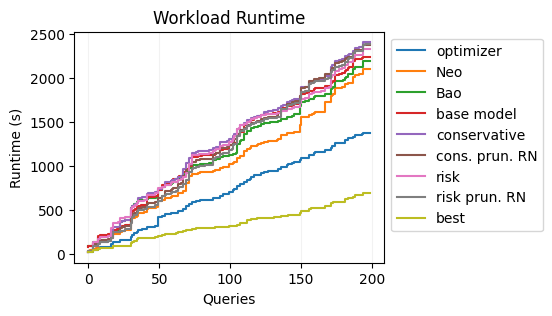

In [111]:
labels = [
                 'optimizer',#'optimizer pruned',
                 'Neo','Bao',
                #  'Neo+','Bao+',
                 'base model',#'base model pruned',
                #  'mc dropout',
                 'conservative','cons. prun. RN',
                 'risk','risk prun. RN',
                'best'
                ]

values = runtimes_all_df.loc[:,labels].values.T

plot_step_curve(values,labels,scale='linear',figsize=[4,3],
                save_to='./plots/runtime_step_ext_{}.png'.format(exp_id),bbox_to_anchor=(1.0, 1.0),show_fig=show_fig)

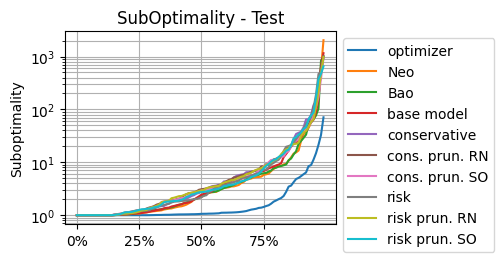

In [112]:
labels = [
        'optimizer',
        # 'optimizer pruned',
        'Neo','Bao',
        'base model',#'base model pruned',
        # 'mc dropout','mc dropout pruned',
        'conservative','cons. prun. RN','cons. prun. SO',
        'risk','risk prun. RN','risk prun. SO',
        ]
values = subopts_all_df.loc[:,labels].values.T

describe_plot(values,labels, 
              metric_label='Suboptimality',
              plot_title='SubOptimality - Test', 
              log_scale = True, figsize=[3.5,2.5],plot_x_every=25,
             bbox_to_anchor=(1.0, 1.0),
             show_fig=show_fig)

In [113]:
sub = agg_res_all_df.loc[labels,:]
sub_var = agg_res_all_var_df.loc[labels,:]

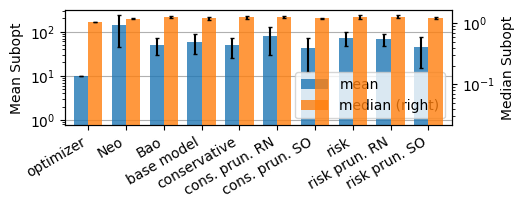

In [114]:
sub.rename({'50%':'median'},axis=1,inplace=True)
sub_var.rename({'50%':'median'},axis=1,inplace=True)
ax=sub.loc[labels,['mean','median']].plot.bar(logy=True,secondary_y=['median'],figsize=[5,1.5],
                yerr=sub_var.loc[labels,['mean','median']],
               align='center', alpha=0.8, ecolor='black', capsize=1.5, width=0.75)
ax.set_xticks(ticks=np.arange(len(labels)),labels=labels,rotation=30,ha='right')
ax.grid(visible=True,which='major',axis='y')
ax.set_axisbelow(True)
# ax.set_xlabel('Plan Selection Strategy')
ax.set_ylabel('Mean Subopt')
ax.right_ax.set_ylabel('Median Subopt')
plt.savefig('./plots/subopt_bar_main_{}.png'.format(exp_id),bbox_inches='tight',dpi=300)
plt.show()

In [115]:
sub

,improved,improved_runtime,average_improvement,regressed,regressed_runtime,average_regression,unchanged,total_runtime_change%,total_runtime_change,average_runtime_change,total_subopt,mean,median,60%,70%,80%,90%,95%,99%,max
optimizer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.611467,1.061358,1.115962,1.274317,1.900826,5.479419,11.230046,70.905492,1218.184147
Neo,0.290,272.459985,4.708707,0.432,995.593481,11.501373,0.278,0.526038,723.133495,3.615667,1.526038,141.885117,1.191575,1.538454,3.137588,5.534757,16.168891,63.685933,1800.423629,19402.975606
Bao,0.247,230.477710,4.642163,0.444,1048.170538,11.858272,0.309,0.594825,817.692828,4.088464,1.594825,51.132046,1.294837,1.735878,3.129212,5.918261,16.996753,57.984050,913.857688,5164.994064
base model,0.253,239.403040,4.751634,0.435,1105.848293,12.767067,0.312,0.630289,866.445252,4.332226,1.630289,59.260645,1.219321,1.673136,3.873532,6.927118,18.670014,61.814041,1082.735362,6205.951755
conservative,0.266,302.511510,5.689197,0.517,1331.344592,12.852747,0.217,0.748417,1028.833082,5.144165,1.748417,48.715286,1.257611,1.736570,4.078953,7.475273,23.209613,78.732834,1005.113574,4616.697624
cons. prun. RN,0.260,260.805306,5.013069,0.516,1257.200757,12.178995,0.224,0.724821,996.395451,4.981977,1.724821,78.115238,1.261681,1.812833,3.861316,6.897834,23.463198,72.510973,1244.327577,8360.802409
cons. prun. SO,0.285,306.097960,5.381650,0.506,1080.826786,10.690330,0.209,0.563571,774.728826,3.873644,1.563571,42.109858,1.217541,1.732160,3.663269,6.448127,20.304699,62.721227,1096.117514,4030.401993
risk,0.283,274.668495,4.795518,0.493,1230.657975,12.391233,0.224,0.695428,955.989480,4.779947,1.695428,72.816950,1.270053,1.845797,3.899916,7.042211,20.986585,70.515189,1099.382172,8434.858092
risk prun. RN,0.292,266.122779,4.569992,0.498,1270.006720,12.806528,0.210,0.730268,1003.883941,5.019420,1.730268,67.804997,1.292404,1.885473,4.073565,6.972963,23.775947,55.650526,786.224126,8624.226472
risk prun. SO,0.301,268.614884,4.472452,0.480,1073.506369,11.228699,0.219,0.585512,804.891486,4.024457,1.585512,45.400147,1.227475,1.651461,3.457280,6.014203,20.426360,56.672475,812.734520,4278.119162


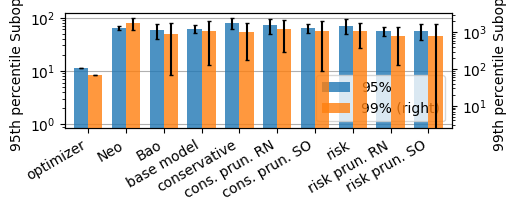

In [116]:
sub.rename({'50%':'median'},axis=1,inplace=True)
sub_var.rename({'50%':'median'},axis=1,inplace=True)
ax=sub.loc[labels,['95%','99%']].plot.bar(logy=True,secondary_y=['99%'],figsize=[5,1.5],
                yerr=sub_var.loc[labels,['95%','99%']],
               align='center', alpha=0.8, ecolor='black', capsize=1.5, width=0.75)
ax.set_xticks(ticks=np.arange(len(labels)),labels=labels,rotation=30,ha='right')
ax.grid(visible=True,which='major',axis='y')
ax.set_axisbelow(True)
# ax.set_xlabel('Plan Selection Strategy')
ax.set_ylabel('95th percentile Subopt')
ax.right_ax.set_ylabel('99th percentile Subopt')
plt.savefig('./plots/subopt_bar_tail_{}.png'.format(exp_id),bbox_inches='tight',dpi=300)
plt.show()

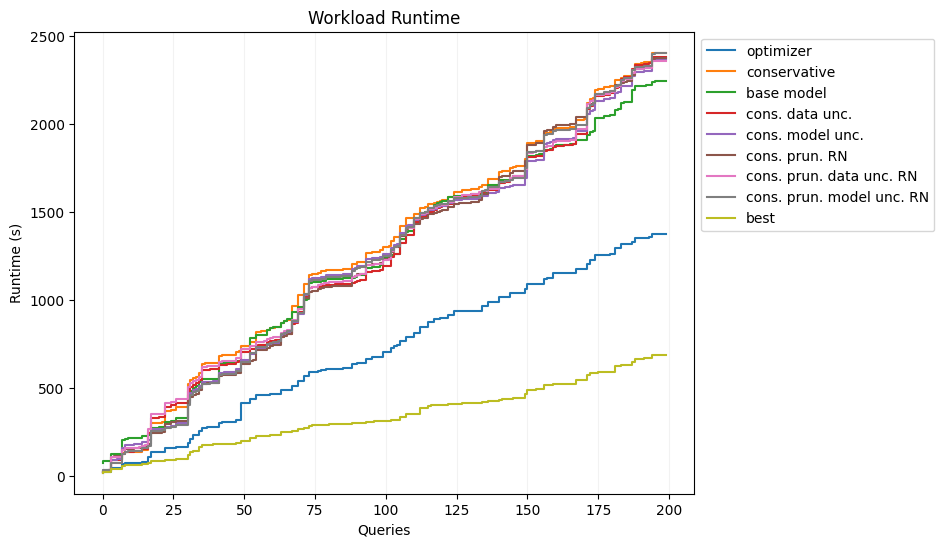

In [117]:
labels = [
                 'optimizer',
                 'conservative',
                 'base model',
                 'cons. data unc.', 
                 'cons. model unc.',
                 'cons. prun. RN', 
                 'cons. prun. data unc. RN', 
                 'cons. prun. model unc. RN',
                 'best'
                ]
values = runtimes_all_df.loc[:,labels].values.T

plot_step_curve(values,labels,scale='linear',figsize=[8,6],
                bbox_to_anchor=(1.0, 1.0),show_fig=show_fig)


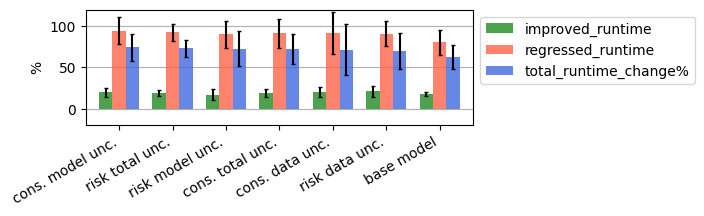

In [118]:
labels = [
                 'base model',
                 'cons. prun. RN',
                 'cons. prun. data unc. RN',
                 'cons. prun. model unc. RN',
                 'risk prun. RN', 
                 'risk prun. data unc. RN', 
                 'risk prun. model unc. RN', 
                ]

chart_labels = ['base model',
           'cons. total unc.','cons. data unc.','cons. model unc.',
           'risk total unc.','risk data unc.','risk model unc.'
           ]

features = ["improved_runtime","regressed_runtime","total_runtime_change%"]

sub = agg_res_all_df.loc[labels,features]
sub_var = agg_res_all_var_df.loc[labels,features]

sub.index=chart_labels
sub_var.index=chart_labels

sub = sub.sort_values(by='total_runtime_change%',ascending=False)
sub_perc = sub.copy()
sub_var_perc = sub_var.copy()
sub_perc[["improved_runtime","regressed_runtime"]] = sub_perc[["improved_runtime","regressed_runtime"]]/runtimes_all_df.optimizer.sum()
sub_var_perc[["improved_runtime","regressed_runtime"]] = sub_var_perc[["improved_runtime","regressed_runtime"]]/runtimes_all_df.optimizer.sum()
sub_perc=sub_perc*100
sub_var_perc=sub_var_perc*100

sub = sub.sort_values(by='total_runtime_change%',ascending=False)
ax = sub_perc.plot.bar(logy=False,figsize=[5,1.5],
            color=['forestgreen','tomato','royalblue'], yerr=sub_var_perc,
               align='center', alpha=0.8, ecolor='black', capsize=1.5, width=.75)
plt.legend(bbox_to_anchor=(1, 1))
plt.xticks(rotation=30,ha='right')
plt.ylabel('%')
ax.grid(visible=True,which='both',axis='y')
ax.set_ylim((-20,120))
ax.set_axisbelow(True)
# plt.show()
plt.savefig('./plots/runtime_bar_mode_data_unc_{}.png'.format(exp_id),bbox_inches='tight',dpi=300)

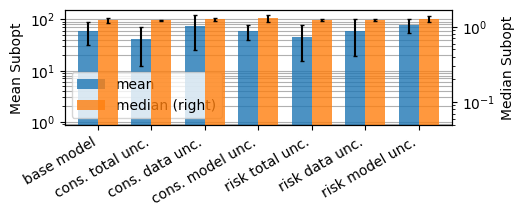

In [119]:
labels = [
                 'base model',
                 'cons. prun. SO',
                 'cons. prun. data unc. SO',
                 'cons. prun. model unc. SO',
                 'risk prun. SO', 
                 'risk prun. data unc. SO', 
                 'risk prun. model unc. SO', 
                ]

chart_labels = [
    'base model',
           'cons. total unc.','cons. data unc.','cons. model unc.',
           'risk total unc.','risk data unc.','risk model unc.'
           ]

features=['mean','50%']

sub = agg_res_all_df.loc[labels,features]
sub_var = agg_res_all_var_df.loc[labels,features]

sub.index=chart_labels
sub_var.index=chart_labels

sub.rename({'50%':'median'},axis=1,inplace=True)
sub_var.rename({'50%':'median'},axis=1,inplace=True)
ax=sub.plot.bar(logy=True,secondary_y=['median'],figsize=[5,1.5],
                yerr=sub_var,
               align='center', alpha=0.8, ecolor='black', capsize=1.5, width=.75)
ax.set_xticks(ticks=np.arange(len(chart_labels)),labels=chart_labels,rotation=30,ha='right')
ax.grid(visible=True,which='both',axis='y')
ax.set_axisbelow(True)
# ax.set_xlabel('Plan Selection Strategy')
ax.set_ylabel('Mean Subopt')
ax.right_ax.set_ylabel('Median Subopt')
plt.savefig('./plots/subopt_bar_mode_data_unc_{}.png'.format(exp_id),bbox_inches='tight',dpi=300)
plt.show()

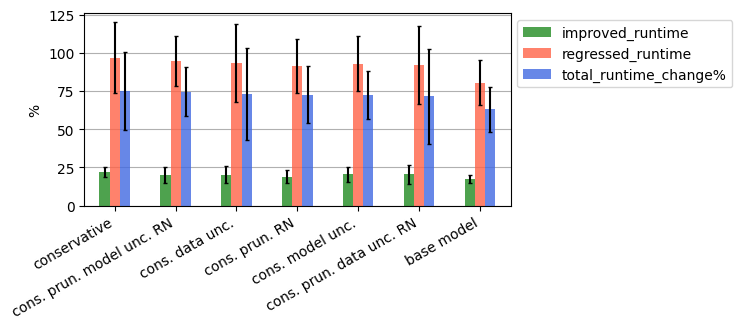

In [120]:
labels = [
                 'base model',
                 'conservative',
                 'cons. data unc.', 
                 'cons. model unc.',
                 'cons. prun. RN',
                 'cons. prun. data unc. RN',
                 'cons. prun. model unc. RN',
                ]
features = ["improved_runtime","regressed_runtime","total_runtime_change%"]

sub = agg_res_all_df.loc[labels,features]
sub_var = agg_res_all_var_df.loc[labels,features]

sub = sub.sort_values(by='total_runtime_change%',ascending=False)
sub_perc = sub.copy()
sub_var_perc = sub_var.copy()
sub_perc[["improved_runtime","regressed_runtime"]] = sub_perc[["improved_runtime","regressed_runtime"]]/runtimes_all_df.optimizer.sum()
sub_var_perc[["improved_runtime","regressed_runtime"]] = sub_var_perc[["improved_runtime","regressed_runtime"]]/runtimes_all_df.optimizer.sum()
sub_perc=sub_perc*100
sub_var_perc=sub_var_perc*100

sub = sub.sort_values(by='total_runtime_change%',ascending=False)
ax = sub_perc.plot.bar(logy=False,figsize=[5.5,2.5],
            color=['forestgreen','tomato','royalblue'], yerr=sub_var_perc,
               align='center', alpha=0.8, ecolor='black', capsize=1.5)
plt.legend(bbox_to_anchor=(1, 1))
plt.xticks(rotation=30,ha='right')
plt.ylabel('%')
ax.grid(visible=True,which='major',axis='y')
ax.set_axisbelow(True)
# plt.show()
plt.savefig('./plots/runtime_bar_cons_{}.png'.format(exp_id),bbox_inches='tight',dpi=300)

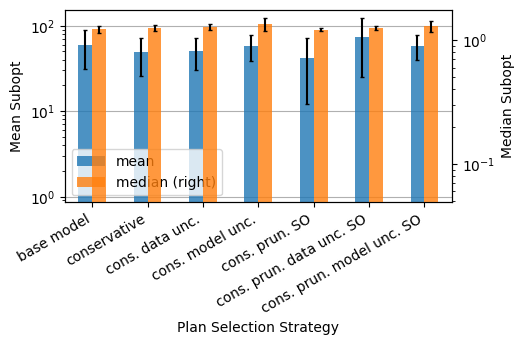

In [121]:
labels = [
                 'base model',
                 'conservative',
                 'cons. data unc.', 
                 'cons. model unc.',
                 'cons. prun. SO',
                 'cons. prun. data unc. SO',
                 'cons. prun. model unc. SO',
                ]

sub = agg_res_all_df.loc[labels,:]
sub_var = agg_res_all_var_df.loc[labels,:]

sub.rename({'50%':'median'},axis=1,inplace=True)
sub_var.rename({'50%':'median'},axis=1,inplace=True)
ax=sub.loc[labels,['mean','median']].plot.bar(logy=True,secondary_y=['median'],figsize=[5,2.5],
                yerr=sub_var.loc[labels,['mean','median']],
               align='center', alpha=0.8, ecolor='black', capsize=1.5)
ax.set_xticks(ticks=np.arange(len(labels)),labels=labels,rotation=30,ha='right')
ax.grid(visible=True,which='major',axis='y')
ax.set_axisbelow(True)
ax.set_xlabel('Plan Selection Strategy')
ax.set_ylabel('Mean Subopt')
ax.right_ax.set_ylabel('Median Subopt')
plt.savefig('./plots/subopt_bar_cons_{}.png'.format(exp_id),bbox_inches='tight',dpi=300)
plt.show()

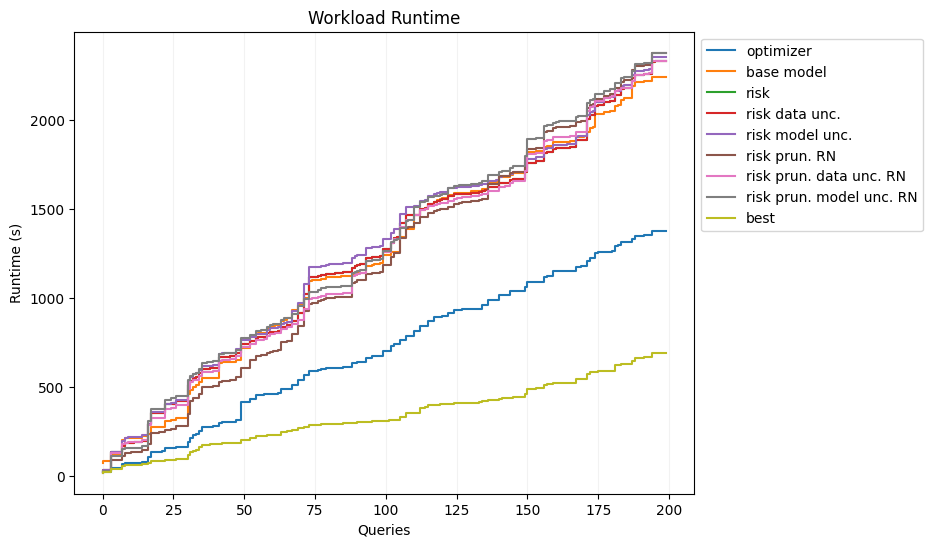

In [122]:
labels = [
                 'optimizer',
                 'base model',
                 'risk',
                 'risk data unc.', 
                 'risk model unc.',
                 'risk prun. RN', 
                 'risk prun. data unc. RN', 
                 'risk prun. model unc. RN', 
                 'best'
                ]

values = runtimes_all_df.loc[:,labels].values.T

plot_step_curve(values,labels,scale='linear',figsize=[8,6],
                bbox_to_anchor=(1.0, 1.0),show_fig=show_fig)

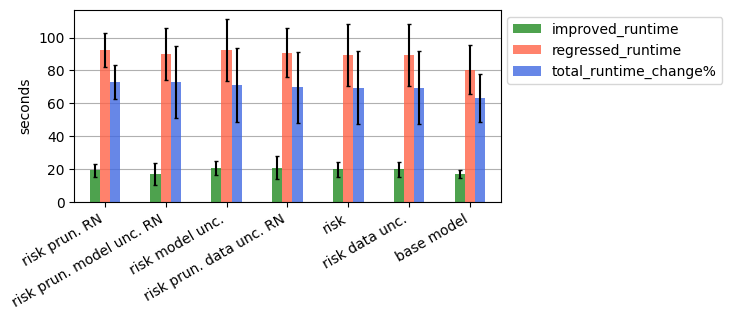

In [123]:
labels = [
                 'base model',
                 'risk',
                 'risk data unc.', 
                 'risk model unc.',
                 'risk prun. RN', 
                 'risk prun. data unc. RN', 
                 'risk prun. model unc. RN', 
                ]
features = ["improved_runtime","regressed_runtime","total_runtime_change%"]

sub = agg_res_all_df.loc[labels,features]
sub_var = agg_res_all_var_df.loc[labels,features]

sub = sub.sort_values(by='total_runtime_change%',ascending=False)
sub_perc = sub.copy()
sub_var_perc = sub_var.copy()
sub_perc[["improved_runtime","regressed_runtime"]] = sub_perc[["improved_runtime","regressed_runtime"]]/runtimes_all_df.optimizer.sum()
sub_var_perc[["improved_runtime","regressed_runtime"]] = sub_var_perc[["improved_runtime","regressed_runtime"]]/runtimes_all_df.optimizer.sum()
sub_perc=sub_perc*100
sub_var_perc=sub_var_perc*100

sub = sub.sort_values(by='total_runtime_change%',ascending=False)
ax = sub_perc.plot.bar(logy=False,figsize=[5.5,2.5],
            color=['forestgreen','tomato','royalblue'], yerr=sub_var_perc,
               align='center', alpha=0.8, ecolor='black', capsize=1.5)
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.xticks(rotation=30,ha='right')
plt.ylabel('seconds')
ax.grid(visible=True,which='major',axis='y')
ax.set_axisbelow(True)
# plt.show()
plt.savefig('./plots/runtime_bar_risk_{}.png'.format(exp_id),bbox_inches='tight',dpi=300)

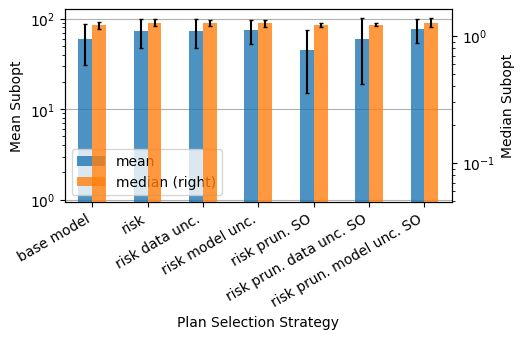

In [124]:
labels = [
                'base model',
                 'risk',
                 'risk data unc.', 
                 'risk model unc.',
                 'risk prun. SO', 
                 'risk prun. data unc. SO', 
                 'risk prun. model unc. SO', 
                ]

sub = agg_res_all_df.loc[labels,:]
sub_var = agg_res_all_var_df.loc[labels,:]

sub.rename({'50%':'median'},axis=1,inplace=True)
sub_var.rename({'50%':'median'},axis=1,inplace=True)

ax=sub.loc[labels,['mean','median']].plot.bar(logy=True,secondary_y=['median'],figsize=[5,2.5],
                yerr=sub_var.loc[labels,['mean','median']],
               align='center', alpha=0.8, ecolor='black', capsize=1.5)
ax.set_xticks(ticks=np.arange(len(labels)),labels=labels,rotation=30,ha='right')
ax.grid(visible=True,which='major',axis='y')
ax.set_axisbelow(True)
ax.set_xlabel('Plan Selection Strategy')
ax.set_ylabel('Mean Subopt')
ax.right_ax.set_ylabel('Median Subopt')
plt.savefig('./plots/subopt_bar_risk_{}.png'.format(exp_id),bbox_inches='tight',dpi=300)
plt.show()

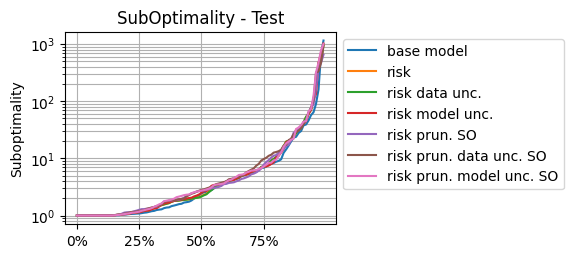

In [125]:
values = subopts_all_df.loc[:,labels].values.T

describe_plot(values,labels, 
              metric_label='Suboptimality',
              plot_title='SubOptimality - Test', 
              log_scale = True, figsize=[3.5,2.5],plot_x_every=25,
             save_to = './plots/sub_opt_line.png',
             bbox_to_anchor=(1.0, 1.0),
             show_fig=show_fig)

In [126]:
qerror_all = []
for i in qerror_dict:
    qerror_all.append(qerror_dict[i].values)
qerror_all=np.array(qerror_all)
qerror_all_df = qerror_dict[0].copy()
qerror_all_var_df = qerror_dict[0].copy()
qerror_all_df.loc[:, :] = qerror_all.mean(axis=0)
qerror_all_var_df.loc[:, :] = qerror_all.std(axis=0)

In [127]:
labels=['Bao','Neo','Roq']

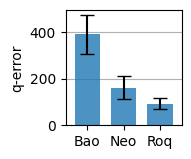

In [128]:
y = qerror_all_df[labels].mean(axis=0)
yerr = qerror_all_var_df[labels].mean(axis=0)
ax =y.plot.bar(logy=False,figsize=[1.5,1.5],yerr=yerr.T.values,
               align='center', alpha=0.8, ecolor='black', capsize=5,
               width=0.7)
ax.grid(visible=True,which='both',axis='y')
ax.set_axisbelow(True)
ax.set_ylabel('q-error')
plt.xticks(rotation=0,ha='center')
# plt.legend(bbox_to_anchor=(1.0,1.0))
plt.savefig('./plots/qerror_bar_{}.png'.format(exp_id),bbox_inches='tight',dpi=300)
plt.show()

In [129]:
res = qerror_all_df.describe(percentiles=[.5,.6,.7,.8,.90,.95,.99]).T
res.loc[:,['mean','std','50%','60%','70%','80%','90%','99%','max']]

,mean,std,50%,60%,70%,80%,90%,99%,max
Bao,388.496704,2040.518555,6.234984,8.889310,14.305520,40.152815,191.257632,11002.545635,43243.957031
Neo,161.624435,910.944275,3.647824,5.693093,10.609789,22.377659,138.397946,4094.889626,18531.699219
Roq,92.559685,777.479614,4.622288,6.527396,11.581446,22.001737,56.710242,1926.220808,19112.230469
Roq MCDO,92.921021,786.336670,4.756378,6.595479,11.582442,22.518450,55.789459,1875.739792,19479.261719


In [130]:
res = qerror_all_var_df.describe(percentiles=[.5,.6,.7,.8,.90,.95,.99]).T
res.loc[:,['mean','50%','60%','70%','80%','90%','99%','max']]


,mean,50%,60%,70%,80%,90%,99%,max
Bao,82.231697,1.170373,1.778915,2.995295,7.144965,28.314824,2205.776318,9297.545898
Neo,47.334137,1.153995,1.691090,2.645771,7.439990,43.757501,1222.714822,4210.685059
Roq,23.819714,1.059516,1.703692,3.261527,6.100631,17.088778,558.740313,3075.310303
Roq MCDO,24.596718,1.121792,1.754871,3.300168,6.361326,17.818802,557.921251,2872.274414


In [131]:
corr_all = []
for i in corr_dict:
    corr_all.append(corr_dict[i].values)
corr_all=np.array(corr_all)
corr_all_df = corr_dict[0].copy()
corr_all_var_df = corr_dict[0].copy()
corr_all_df.loc[:, :] = corr_all.mean(axis=0)
corr_all_var_df.loc[:, :] = corr_all.std(axis=0)

In [132]:
corr_all_df

,Cost,Bao,Neo,Roq,Roq MCDO
Pearson,0.091012,0.145073,0.348190,0.340199,0.338899
Spearman,0.592856,0.220088,0.576229,0.602297,0.602214


In [133]:
corr_all_var_df

,Cost,Bao,Neo,Roq,Roq MCDO
Pearson,0.0,0.018314,0.010557,0.020306,0.020003
Spearman,0.0,0.030237,0.012484,0.018995,0.018984


In [134]:
labels = ['Cost','Bao','Neo','Roq']

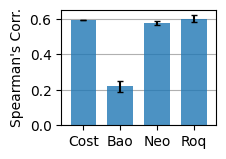

In [135]:

ax =corr_all_df.T[['Spearman']].loc[labels].plot.bar(logy=False,figsize=[2,1.5],yerr=corr_all_var_df.T[['Spearman']].loc[labels].T.values,
               align='center', alpha=0.8, ecolor='black', capsize=2.5,
               width=0.7)

ax.grid(visible=True,which='both',axis='y')
ax.set_axisbelow(True)
ax.set_ylabel('Spearman\'s Corr.')
# plt.ylim((0.4,0.75))
plt.xticks(rotation=0,ha='center')
legend = ax.legend()
legend.remove()

plt.savefig('./plots/spearman_corr_bar_{}.png'.format(exp_id),bbox_inches='tight',dpi=300)
plt.show()

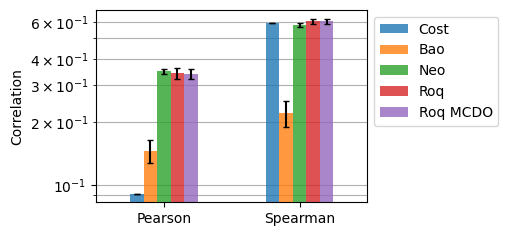

In [136]:
ax =corr_all_df.plot.bar(logy=True,figsize=[3.5,2.5],yerr=corr_all_var_df.T.values,
               align='center', alpha=0.8, ecolor='black', capsize=2.5)
ax.grid(visible=True,which='both',axis='y')
ax.set_axisbelow(True)
ax.set_ylabel('Correlation')
plt.xticks(rotation=0,ha='center')
plt.legend(bbox_to_anchor=(1.0,1.0))
plt.show()